In [65]:
"""
1. データセットとデータローダーを用意
"""

import torch
import torchvision.datasets as datasets
import torchvision.transforms as transforms

# MNISTデータセットの訓練データを用意
dataset = datasets.MNIST(
    # mnistフォルダーに保存
    # パスは環境に合わせて書き換えることが必要
    # root='/content/drive/MyDrive/Colab Notebooks/C-GAN/C-GAN_PyTorch/mnist',
    root="mnist",
    download=True,
    train=True,
    # トランスフォームオブジェクトを設定
    transform=transforms.Compose(
        [
            transforms.ToTensor(),
            # データを平均0.5、標準偏差0.5の標準正規分布で正規化
            # チャネル数は1なのでタプルの要素も1
            transforms.Normalize((0.5,), (0.5,)),
        ]
    ),
)

# ミニバッチのサイズ
batch_size = 50

# 訓練データをセットしたデータローダーを作成する
dataloader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, shuffle=True  # ミニバッチのサイズは50
)  # データをシャッフルしてから抽出

# 使用可能なデバイスを確認
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("device:", device)

device: cuda:0


In [67]:
print(dataset)

Dataset MNIST
    Number of datapoints: 60000
    Root location: mnist
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )


In [66]:
"""
2. 識別器のクラスを定義 
"""

import torch.nn as nn


class Discriminator(nn.Module):
    """識別器のクラス

    Attributes:
      layers: Sequentialオブジェクトのリスト
    """

    def __init__(self):
        """識別器のネットワークを構築する"""
        super(Discriminator, self).__init__()

        start_ch = 128  # 先頭層の出力チャネル数
        in_ch = 1 + 10  # 入力画像のチャネル数

        # 識別器のネットワークを定義する
        self.layers = nn.ModuleList(
            [
                # 第1層: (bs, 11, 28, 28) -> (bs, 128, 14, 14)
                nn.Sequential(
                    # 畳み込み
                    nn.Conv2d(
                        in_ch,  # 入力のチャネル数は1
                        start_ch,  # フィルター数は128
                        4,  # 4×4のフィルター
                        2,  # ストライドは2
                        1,
                    ),  # 上下左右にサイズ1のパディング
                    # LeakyReLU関数を適用
                    # 負の勾配を制御する係数を0.2(デフォルトは0.01)
                    nn.LeakyReLU(negative_slope=0.2),
                ),
                # 第2層: (bs, 128, 14, 14) -> (bs, 256, 7, 7)
                nn.Sequential(
                    # 畳み込み
                    nn.Conv2d(
                        start_ch,  # 入力のチャネル数は128
                        start_ch * 2,  # フィルター数は128×2
                        4,  # 4×4のフィルター
                        2,  # ストライドは2
                        1,
                    ),  # 上下左右にサイズ1のパディング
                    # 出力値を正規化する(チャネル数は128×2)
                    nn.BatchNorm2d(start_ch * 2),
                    # LeakyReLU関数を適用
                    nn.LeakyReLU(negative_slope=0.2),
                ),
                # 第3層: (bs, 256, 7, 7) -> (bs, 512, 3, 3)
                nn.Sequential(
                    # 畳み込み
                    nn.Conv2d(
                        start_ch * 2,  # 入力のチャネル数は128×2
                        start_ch * 4,  # フィルター数は128×4
                        3,  # 3×3のフィルター
                        2,  # ストライドは2
                        0,
                    ),  # パディングは0(なし)
                    # 出力値を正規化する(チャネル数は128×4)
                    nn.BatchNorm2d(start_ch * 4),
                    # leaky ReLU関数を適用
                    nn.LeakyReLU(negative_slope=0.2),
                ),
                # 第4層: (bs, 512, 3, 3) -> (bs, 1, 1, 1)
                nn.Sequential(
                    nn.Conv2d(
                        start_ch * 4,  # 入力のチャネル数は128×4
                        1,  # フィルター数は1
                        3,  # 3×3のフィルター
                        1,  # ストライドは1
                        0,
                    ),  # パディングは0(なし)
                    # 最終出力にはシグモイド関数を適用
                    nn.Sigmoid(),
                ),
            ]
        )

    def forward(self, x):
        """順伝播処理

        Parameter:
          x: 画像データまたは生成画像
        """
        # 識別器のネットワークに入力して順伝播する
        for layer in self.layers:
            x = layer(x)
        # 出力されたテンソルの形状をフラット(bs,)にする
        return x.squeeze()

In [68]:
"""
3. 生成器のクラスを定義
"""


class Generator(nn.Module):
    """生成器のクラス

    Attributes:
      layers: Sequentialオブジェクトのリスト
    """

    def __init__(self):
        """生成器のネットワークを構築する"""
        super(Generator, self).__init__()

        input_dim = 100 + 10  # 入力データの次元
        out_ch = 128  # 最終層のチャネル数
        img_ch = 1  # 生成画像のチャネル数

        # 生成器のネットワークを定義する
        self.layers = nn.ModuleList(
            [
                # 第1層: (bs, 110, 1, 1) -> (bs, 512, 3, 3)
                nn.Sequential(
                    nn.ConvTranspose2d(
                        input_dim,  # 入力のチャネル数は100
                        out_ch * 4,  # フィルター数は128×4
                        3,  # 3×3のフィルター
                        1,  # ストライドは1
                        0,
                    ),  # パディングは0(なし)
                    # 出力値を正規化する(チャネル数は128×4)
                    nn.BatchNorm2d(out_ch * 4),
                    # ReLU関数を適用
                    nn.ReLU(),
                ),
                # 第2層: (bs, 512, 3, 3) -> (bs, 256, 7, 7)
                nn.Sequential(
                    nn.ConvTranspose2d(
                        out_ch * 4,  # 入力のチャネル数は128×4
                        out_ch * 2,  # フィルター数は128×2
                        3,  # 3×3のフィルター
                        2,  # ストライドは2
                        0,
                    ),  # パディングは0(なし)
                    # 出力値を正規化する(チャネル数は128×2)
                    nn.BatchNorm2d(out_ch * 2),
                    # ReLU関数を適用
                    nn.ReLU(),
                ),
                # 第3層: (bs, 256, 7, 7) -> (bs, 128, 14, 14)
                nn.Sequential(
                    nn.ConvTranspose2d(
                        out_ch * 2,  # 入力のチャネル数は128×2
                        out_ch,  # フィルター数は128
                        4,  # 4×4のフィルター
                        2,  # ストライドは2
                        1,
                    ),  # 上下左右にサイズ1のパディング
                    # 出力値を正規化する(チャネル数は128)
                    nn.BatchNorm2d(out_ch),
                    # ReLU関数を適用
                    nn.ReLU(),
                ),
                # 第4層: (bs, 128, 14, 14) -> (bs, 1, 28, 28)
                nn.Sequential(
                    nn.ConvTranspose2d(
                        out_ch,  # 入力のチャネル数は128
                        img_ch,  # フィルター数は1
                        4,  # 4×4のフィルター
                        2,  # ストライドは2
                        1,
                    ),  # 上下左右にサイズ1のパディング
                    # Tanh関数を適用
                    nn.Tanh(),
                ),
            ]
        )

    def forward(self, z):
        """順伝播処理

        Parameter:
          z: 識別器の出力
        """
        # 生成器のネットワークに入力して順伝播する
        for layer in self.layers:
            z = layer(z)
        return z

In [69]:
"""
4. 重みの初期化を行う関数
"""


def weights_init(m):
    """
    ネットワークの重みを正規分布からサンプリングした値で初期化する

    Parameters:
      m: ネットワークのインスタンス
    """
    classname = m.__class__.__name__
    # 畳み込み層の重み
    if classname.find("Conv") != -1:
        m.weight.data.normal_(0.0, 0.02)  # 平均0、標準偏差0.02の正規分布
        m.bias.data.fill_(0)  # バイアスのみ0で初期化
    # バッチ正規化層の重み
    elif classname.find("BatchNorm") != -1:
        m.weight.data.normal_(1.0, 0.02)  # 平均1.0、標準偏差0.02の正規分布
        m.bias.data.fill_(0)  # バイアスのみ0で初期化

In [70]:
"""
5. 生成器をインスタンス化して重みを初期化する
"""

import torchsummary

# 生成器をインスタンス化
generator = Generator().to(device)
# 重みを初期化
generator.apply(weights_init)
# 生成器のサマリを出力
torchsummary.summary(generator, (110, 1, 1))  # 入力テンソルの形状

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 512, 3, 3]         507,392
       BatchNorm2d-2            [-1, 512, 3, 3]           1,024
              ReLU-3            [-1, 512, 3, 3]               0
   ConvTranspose2d-4            [-1, 256, 7, 7]       1,179,904
       BatchNorm2d-5            [-1, 256, 7, 7]             512
              ReLU-6            [-1, 256, 7, 7]               0
   ConvTranspose2d-7          [-1, 128, 14, 14]         524,416
       BatchNorm2d-8          [-1, 128, 14, 14]             256
              ReLU-9          [-1, 128, 14, 14]               0
  ConvTranspose2d-10            [-1, 1, 28, 28]           2,049
             Tanh-11            [-1, 1, 28, 28]               0
Total params: 2,215,553
Trainable params: 2,215,553
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forw

In [71]:
"""
6. 識別器をインスタンス化して重みを初期化する
"""

# 識別器をインスタンス化
discriminator = Discriminator().to(device)
# 重みを初期化
discriminator.apply(weights_init)
# 識別器のサマリを出力
torchsummary.summary(discriminator, (11, 28, 28))  # 入力テンソルの形状

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 128, 14, 14]          22,656
         LeakyReLU-2          [-1, 128, 14, 14]               0
            Conv2d-3            [-1, 256, 7, 7]         524,544
       BatchNorm2d-4            [-1, 256, 7, 7]             512
         LeakyReLU-5            [-1, 256, 7, 7]               0
            Conv2d-6            [-1, 512, 3, 3]       1,180,160
       BatchNorm2d-7            [-1, 512, 3, 3]           1,024
         LeakyReLU-8            [-1, 512, 3, 3]               0
            Conv2d-9              [-1, 1, 1, 1]           4,609
          Sigmoid-10              [-1, 1, 1, 1]               0
Total params: 1,733,505
Trainable params: 1,733,505
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.03
Forward/backward pass size (MB): 0.78
Params size (MB): 6.61
Estimat

In [72]:
"""
7. 損失関数とオプティマイザーの設定
"""

import torch.optim as optim

# 損失関数はバイナリクロスエントロピー誤差
criterion = nn.BCELoss()
# 識別器のオプティマイザ−を設定
optimizer_ds = optim.Adam(discriminator.parameters(), lr=0.0003)  # 学習率: デフォルトは0.001
# 生成器のオプティマイザーを設定
optimizer_gn = optim.Adam(generator.parameters(), lr=0.0003)

In [73]:
"""
8. 正解ラベルをOne-hot化する関数
"""


def encoder(label, device, n_class=10):
    """正解ラベルをOne-hot表現に変換する
    Parameters:
      label: 変換対象の正解ラベル
      device: 使用するデバイス
      n_class: 分類先のクラス数
    """
    # 対角成分の値が1の対角行列を作成
    # 2階テンソル(クラスの数, クラスの数)が作成される
    one_hot = torch.eye(n_class, device=device)
    # ラベルの値のインデックスのOne-hot表現を抽出し、
    # 生成器が入力する(バッチサイズ, クラス数, 1, 1)の形状にして返す
    return one_hot[label].view(-1, n_class, 1, 1)

In [74]:
"""
9. 画像のテンソルとラベルのテンソルを結合する関数
"""


def concat_img_label(image, label, device, n_class=10):
    """画像のテンソルとラベルのテンソルを連結して
       識別器に入力するテンソルを作成する

    Parameters:
      image: 画像データを格納したテンソル(bs, 1, 28, 28)
      label: 正解ラベル
      device: 使用可能なデバイス
      n_class: 分類先のクラス数
    Return:
      画像とOne-hot化ラベルを結合したテンソル
      (bs, 11, 28, 28)
    """
    # 画像が格納されたテンソルの形状を取得する
    bs, ch, h, w = image.shape
    # ラベルをOne-hot表現に変換
    oh_label = encoder(label, device)
    # 画像のサイズに合わせて正解ラベルを(bs, 10, 28, 28)に拡張する
    oh_label = oh_label.expand(bs, n_class, h, w)
    # 画像(bs, 1(チャネル), 28, 28)とチャネル方向(dim=1)で結合して戻り値とする
    return torch.cat((image, oh_label), dim=1)

In [75]:
"""
10. ノイズのテンソルとラベルのテンソルを連結する関数
"""


def concat_noise_label(noise, label, device):
    """ノイズのテンソルとラベルのテンソルを連結して
       生成器に入力するテンソルを作成する

    Parameters:
      noise(Tensor): ノイズのテンソル(bs, 100, 1, 1)
      label(int): 正解ラベル
      device: 使用するデバイス
    Return:
      ノイズとOne-hot化ラベルを連結したテンソル
      (bs, 110, 1, 1)
    """
    # ラベルをOne-hot化
    oh_label = encoder(label, device)
    # ノイズ(bs, 100, 1, 1)とOne-hot化ラベルを
    # dim=1で連結して戻り値とする
    return torch.cat((noise, oh_label), dim=1)

In [76]:
"""
11. エポックごとの画像生成に使用するノイズのテンソルを作成
"""

# ノイズの次元数
noise_num = 100

# 生成器のエポックごとの画像生成に使用するノイズのテンソルを作成
# バッチデータと同じ数だけ作成(bs, 100, 1, 1)
fixed_noise = torch.randn(
    batch_size, noise_num, 1, 1, device=device  # バッチサイズ  # ノイズの次元100  # 1  # 1
)
# 正解ラベル0～9をバッチデータの数だけ繰り返す
# 配列の要素数はバッチデータの数と同じ
fixed_label = [i for i in range(10)] * (batch_size // 10)
# ノイズ用の正解ラベルを1階テンソルに変換: (bs,)
fixed_label = torch.tensor(fixed_label, dtype=torch.long, device=device)
# ノイズ(bs, 100, 1, 1)とOne-hot化したラベル(バッチサイズ, クラス数, 1, 1)を
# 連結したテンソル (bs, 110, 1, 1)を作成
fixed_noise_label = concat_noise_label(fixed_noise, fixed_label, device)

### 12. 学習を行う


Epoch 1/10
(1/1200) ds_loss: 1.568 - gn_loss: 2.296 - true_out: 0.507 - fake_out: 0.504>>0.368
(101/1200) ds_loss: 0.041 - gn_loss: 6.442 - true_out: 0.988 - fake_out: 0.027>>0.003
(201/1200) ds_loss: 0.017 - gn_loss: 9.099 - true_out: 0.986 - fake_out: 0.001>>0.000
(301/1200) ds_loss: 0.018 - gn_loss: 5.789 - true_out: 0.997 - fake_out: 0.015>>0.011
(401/1200) ds_loss: 0.086 - gn_loss: 6.480 - true_out: 0.963 - fake_out: 0.032>>0.003
(501/1200) ds_loss: 0.033 - gn_loss: 7.895 - true_out: 0.998 - fake_out: 0.025>>0.009
(601/1200) ds_loss: 0.089 - gn_loss: 6.851 - true_out: 0.943 - fake_out: 0.013>>0.023
(701/1200) ds_loss: 0.035 - gn_loss: 8.167 - true_out: 0.974 - fake_out: 0.002>>0.002
(801/1200) ds_loss: 0.030 - gn_loss: 6.713 - true_out: 0.995 - fake_out: 0.023>>0.004
(901/1200) ds_loss: 0.041 - gn_loss: 7.270 - true_out: 0.969 - fake_out: 0.007>>0.004
(1001/1200) ds_loss: 0.018 - gn_loss: 10.174 - true_out: 0.983 - fake_out: 0.001>>0.000
(1101/1200) ds_loss: 0.204 - gn_loss: 4.350

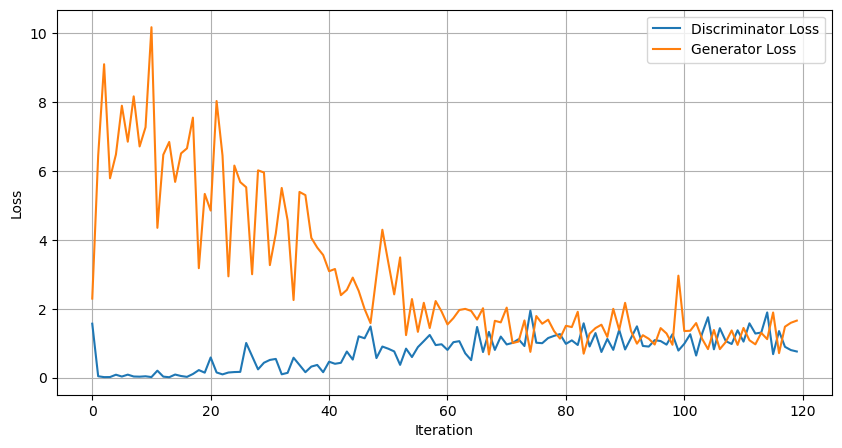

CPU times: user 7min 16s, sys: 1.43 s, total: 7min 17s
Wall time: 7min 6s


In [77]:
%%time
import torchvision.utils as vutils
from matplotlib import pyplot as plt

n_epoch = 10  # 学習回数

# 画像の保存先のパス
# パスは環境に合わせて書き換えることが必要
# outf = '/content/drive/MyDrive/Colab Notebooks/C-GAN/C-GAN_PyTorch/result'
# outf = "result"
outf = "/home/a6000/github/pilot-GAN/C-GAN_PyTorch/result"

# list to save the loss history
ds_losses = []
gn_losses = []

# save initial image (should be random noise)
fake_image = generator(fixed_noise_label)
vutils.save_image(
    fake_image.detach(),
    "{}/fake_samples_epoch_{:03d}.png".format(outf, 0),
    normalize=True,
    nrow=10,
)

# 学習のループ
for epoch in range(n_epoch):
    print("Epoch {}/{}".format(epoch + 1, n_epoch))

    # バッチデータのループ(ステップ)
    for itr, data in enumerate(dataloader):
        # ミニバッチのすべての画像を取得
        real_image = data[0].to(device)
        # ミニバッチのすべての正解ラベルを取得
        real_label = data[1].to(device)
        # 画像とOne-hot化したラベルを連結したテンソルを取得
        # (bs, 11, 28, 28)
        real_image_label = concat_img_label(real_image, real_label, device)  # 画像  # 正解ラベル
        # 標準正規分布からノイズを生成: 出力(bs, 100, 1, 1)
        noise = torch.randn(
            batch_size, noise_num, 1, 1, device=device  # バッチサイズ  # ノイズの次元100  # 1  # 1
        )
        # フェイク画像用の正解ラベルを生成: 出力(bs,)
        fake_label = torch.randint(
            10,  # 0～9のラベルを生成
            (batch_size,),  # バッチデータの数だけ生成
            dtype=torch.long,
            device=device,
        )
        # ノイズとフェイクのラベルを連結: (bs, 110, 1, 1)
        fake_noise_label = concat_noise_label(
            noise, fake_label, device  # (bs, 100, 1, 1)  # (bs,)
        )
        # オリジナル画像に対する識別信号の正解値「1」で初期化した
        # (bs,)の形状のテンソルを生成
        real_target = torch.full((batch_size,), 1.0, device=device)
        # 生成画像に対する識別信号の正解値「0」で初期化した
        # (bs,)の形状のテンソルを生成
        fake_target = torch.full((batch_size,), 0.0, device=device)

        # -----識別器の学習-----
        # 識別器の誤差の勾配を初期化
        discriminator.zero_grad()

        # 識別器に画像とラベルのセットを入力して識別信号を出力
        output = discriminator(real_image_label)
        # オリジナル画像に対する識別値の損失を取得
        ds_real_err = criterion(output, real_target)
        # 1ステップ(1バッチ)におけるオリジナル画像の識別信号の平均
        true_dsout_mean = output.mean().item()

        # ノイズとフェイクのラベルを生成器に入力してフェイク画像を生成
        # (bs, 1, 28, 28)
        fake_image = generator(fake_noise_label)  # (bs, 110, 1, 1)
        # フェイク画像とフェイクのラベルを連結: (bs, 11, 28, 28)
        fake_image_label = concat_img_label(
            fake_image, fake_label, device  # (bs, 1, 28, 28)  # (bs,)
        )

        # フェイク画像とフェイクラベルを識別器に入力して識別信号を出力
        output = discriminator(fake_image_label.detach())
        # フェイク画像を偽と判定できない場合の損失
        ds_fake_err = criterion(
            output, fake_target  # フェイク画像の識別信号
        )  # 正解ラベル(偽物の0)
        # フェイク画像の識別信号の平均
        fake_dsout_mean1 = output.mean().item()
        # オリジナル画像とフェイク画像に対する識別の損失を合計して
        # 識別器としての損失を求める
        ds_err = ds_real_err + ds_fake_err

        # 識別器全体の誤差を逆伝播
        ds_err.backward()
        # 判別器の重みのみを更新(生成器は更新しない)
        optimizer_ds.step()

        # -----生成器の学習-----
        # 生成器の誤差の勾配を初期化
        generator.zero_grad()
        # 更新後の識別器に再度フェイク画像とフェイクラベルを入力して識別信号を取得
        output = discriminator(fake_image_label)
        # フェイク画像をオリジナル画像と誤認できない場合の損失
        gn_err = criterion(
            output, real_target  # フェイク画像の識別信号
        )  # 誤認させるのが目的なので正解ラベルは1
        # 更新後の識別器の誤差を逆伝播
        gn_err.backward()
        # 更新後の識別器のフェイク画像に対する識別信号の平均
        fake_dsout_mean2 = output.mean().item()
        # 生成器の重みを更新後の識別誤差の勾配で更新
        optimizer_gn.step()

        # 100ステップごとに出力
        if itr % 100 == 0:
            ds_losses.append(ds_err.item())
            gn_losses.append(gn_err.item())
            print(
                "({}/{}) ds_loss: {:.3f} - gn_loss: {:.3f} - true_out: {:.3f} - fake_out: {:.3f}>>{:.3f}".format(
                    itr + 1,  # ステップ数(イテレート回数)
                    len(dataloader),  # ステップ数(1エポックのバッチ数)
                    ds_err.item(),  # 識別器の損失
                    gn_err.item(),  # フェイクをオリジナルと誤認しない損失
                    true_dsout_mean,  # オリジナル画像の識別信号の平均
                    fake_dsout_mean1,  # フェイク画像の識別信号の平均
                    fake_dsout_mean2,
                )  # 更新後識別器のフェイクの識別信号平均
            )

        # 学習開始直後にオリジナル画像を保存する
        if epoch == 0 and itr == 0:
            vutils.save_image(
                real_image, "{}/real_samples.png".format(outf), normalize=True, nrow=10
            )

    # 確認用画像の生成
    # 1エポック終了ごとに確認用の生成画像を生成する
    fake_image = generator(fixed_noise_label)
    vutils.save_image(
        fake_image.detach(),
        "{}/fake_samples_epoch_{:03d}.png".format(outf, epoch + 1),
        normalize=True,
        nrow=10,
    )

# 損失のプロット
plt.figure(figsize=(10, 5))
plt.plot(ds_losses, label="Discriminator Loss")
plt.plot(gn_losses, label="Generator Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.savefig("{}/loss_plot.png".format(outf))
plt.show()